In [1]:
#!/usr/bin/env python3
"""
Comprehensive Model Validation Suite
Advanced validation, testing, and performance analysis for sepsis prediction models
"""

'\nComprehensive Model Validation Suite\nAdvanced validation, testing, and performance analysis for sepsis prediction models\n'

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold, learning_curve
from sklearn.metrics import (classification_report, confusion_matrix, roc_auc_score, 
                           roc_curve, precision_recall_curve, average_precision_score,
                           accuracy_score, precision_score, recall_score, f1_score,
                           matthews_corrcoef, cohen_kappa_score)
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
class ModelValidator:
    """Comprehensive model validation class"""
    
    def __init__(self, model_path, scaler_path, feature_names_path):
        """Initialize validator with model components"""
        self.model = joblib.load(model_path)
        self.scaler = joblib.load(scaler_path)
        self.feature_names = joblib.load(feature_names_path)
        self.results = {}
        
    def validate_on_holdout(self, X_test, y_test):
        """Comprehensive validation on holdout test set"""
        print("=== HOLDOUT VALIDATION ===\n")
        
        # Scale test data
        X_test_scaled = self.scaler.transform(X_test)
        
        # Predictions
        y_pred = self.model.predict(X_test_scaled)
        y_pred_proba = self.model.predict_proba(X_test_scaled)[:, 1]
        
        # Basic metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'auc_roc': roc_auc_score(y_test, y_pred_proba),
            'avg_precision': average_precision_score(y_test, y_pred_proba),
            'matthews_corr': matthews_corrcoef(y_test, y_pred),
            'cohen_kappa': cohen_kappa_score(y_test, y_pred)
        }
        
        # Confusion matrix details
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()
        
        metrics.update({
            'specificity': tn / (tn + fp),
            'npv': tn / (tn + fn) if (tn + fn) > 0 else 0,
            'ppv': tp / (tp + fp) if (tp + fp) > 0 else 0,
            'sensitivity': tp / (tp + fn) if (tp + fn) > 0 else 0
        })
        
        self.results['holdout'] = metrics
        
        print("Holdout Test Results:")
        for metric, value in metrics.items():
            print(f"  {metric:15}: {value:.4f}")
        
        return metrics
    
    def cross_validation(self, X, y, cv_folds=5):
        """Comprehensive cross-validation"""
        print(f"\n=== {cv_folds}-FOLD CROSS VALIDATION ===\n")
        
        # Scale data
        X_scaled = self.scaler.fit_transform(X)
        
        # Cross-validation with multiple metrics
        cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
        
        scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
        cv_results = {}
        
        for metric in scoring_metrics:
            scores = cross_val_score(self.model, X_scaled, y, cv=cv, scoring=metric)
            cv_results[metric] = {
                'mean': scores.mean(),
                'std': scores.std(),
                'scores': scores
            }
            print(f"{metric:12}: {scores.mean():.4f} Â± {scores.std():.4f}")
        
        self.results['cross_validation'] = cv_results
        return cv_results
    
    def learning_curves(self, X, y, train_sizes=None):
        """Generate and plot learning curves"""
        print("\n=== LEARNING CURVES ===\n")
        
        if train_sizes is None:
            train_sizes = np.linspace(0.1, 1.0, 10)
        
        X_scaled = self.scaler.fit_transform(X)
        
        train_sizes_abs, train_scores, val_scores = learning_curve(
            self.model, X_scaled, y, 
            train_sizes=train_sizes,
            cv=5, scoring='roc_auc',
            n_jobs=-1, random_state=42
        )
        
        # Plot learning curves
        plt.figure(figsize=(10, 6))
        plt.plot(train_sizes_abs, train_scores.mean(axis=1), 'o-', label='Training AUC')
        plt.fill_between(train_sizes_abs, 
                        train_scores.mean(axis=1) - train_scores.std(axis=1),
                        train_scores.mean(axis=1) + train_scores.std(axis=1), 
                        alpha=0.1)
        
        plt.plot(train_sizes_abs, val_scores.mean(axis=1), 'o-', label='Validation AUC')
        plt.fill_between(train_sizes_abs, 
                        val_scores.mean(axis=1) - val_scores.std(axis=1),
                        val_scores.mean(axis=1) + val_scores.std(axis=1), 
                        alpha=0.1)
        
        plt.xlabel('Training Set Size')
        plt.ylabel('AUC Score')
        plt.title('Learning Curves')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('learning_curves.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        self.results['learning_curves'] = {
            'train_sizes': train_sizes_abs,
            'train_scores': train_scores,
            'val_scores': val_scores
        }
        
        return train_sizes_abs, train_scores, val_scores
    
    def calibration_analysis(self, X_test, y_test):
        """Analyze model calibration"""
        print("\n=== CALIBRATION ANALYSIS ===\n")
        
        X_test_scaled = self.scaler.transform(X_test)
        y_pred_proba = self.model.predict_proba(X_test_scaled)[:, 1]
        
        # Calibration curve
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, y_pred_proba, n_bins=10
        )
        
        # Plot calibration curve
        plt.figure(figsize=(8, 6))
        plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="Model")
        plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
        plt.xlabel('Mean Predicted Probability')
        plt.ylabel('Fraction of Positives')
        plt.title('Calibration Curve')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('calibration_curve.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Calibration metrics
        calibration_error = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
        
        self.results['calibration'] = {
            'calibration_error': calibration_error,
            'fraction_of_positives': fraction_of_positives,
            'mean_predicted_value': mean_predicted_value
        }
        
        print(f"Calibration Error: {calibration_error:.4f}")
        
        return calibration_error
    
    def feature_importance_analysis(self):
        """Analyze and visualize feature importance"""
        print("\n=== FEATURE IMPORTANCE ANALYSIS ===\n")
        
        if hasattr(self.model, 'feature_importances_'):
            importance_df = pd.DataFrame({
                'feature': self.feature_names,
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print("Top 15 Most Important Features:")
            for i, row in importance_df.head(15).iterrows():
                print(f"  {row['feature']:20}: {row['importance']:.4f}")
            
            # Plot feature importance
            plt.figure(figsize=(10, 8))
            top_features = importance_df.head(15)
            plt.barh(range(len(top_features)), top_features['importance'])
            plt.yticks(range(len(top_features)), top_features['feature'])
            plt.xlabel('Feature Importance')
            plt.title('Top 15 Feature Importance')
            plt.gca().invert_yaxis()
            plt.tight_layout()
            plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            self.results['feature_importance'] = importance_df
            return importance_df
        else:
            print("Model does not support feature importance")
            return None
    
    def clinical_validation(self, X_test, y_test):
        """Clinical-specific validation metrics"""
        print("\n=== CLINICAL VALIDATION ===\n")
        
        X_test_scaled = self.scaler.transform(X_test)
        y_pred = self.model.predict(X_test_scaled)
        y_pred_proba = self.model.predict_proba(X_test_scaled)[:, 1]
        
        # Clinical thresholds analysis
        thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
        clinical_metrics = []
        
        for threshold in thresholds:
            y_pred_thresh = (y_pred_proba >= threshold).astype(int)
            
            if len(np.unique(y_pred_thresh)) > 1:  # Avoid division by zero
                precision = precision_score(y_test, y_pred_thresh)
                recall = recall_score(y_test, y_pred_thresh)
                f1 = f1_score(y_test, y_pred_thresh)
            else:
                precision = recall = f1 = 0
            
            clinical_metrics.append({
                'threshold': threshold,
                'precision': precision,
                'recall': recall,
                'f1_score': f1
            })
        
        clinical_df = pd.DataFrame(clinical_metrics)
        
        print("Performance at Different Thresholds:")
        print(clinical_df.round(4))
        
        # Plot threshold analysis
        plt.figure(figsize=(10, 6))
        plt.plot(clinical_df['threshold'], clinical_df['precision'], 'o-', label='Precision')
        plt.plot(clinical_df['threshold'], clinical_df['recall'], 's-', label='Recall')
        plt.plot(clinical_df['threshold'], clinical_df['f1_score'], '^-', label='F1-Score')
        plt.xlabel('Threshold')
        plt.ylabel('Score')
        plt.title('Performance vs Threshold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig('threshold_analysis.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        self.results['clinical_validation'] = clinical_df
        return clinical_df
    
    def generate_report(self):
        """Generate comprehensive validation report"""
        print("\n" + "="*60)
        print("COMPREHENSIVE MODEL VALIDATION REPORT")
        print("="*60)
        
        # Model info
        print(f"\nModel Type: {type(self.model).__name__}")
        print(f"Number of Features: {len(self.feature_names)}")
        
        # Performance summary
        if 'holdout' in self.results:
            print(f"\n--- HOLDOUT TEST PERFORMANCE ---")
            holdout = self.results['holdout']
            print(f"AUC-ROC:     {holdout['auc_roc']:.4f}")
            print(f"Accuracy:    {holdout['accuracy']:.4f}")
            print(f"Precision:   {holdout['precision']:.4f}")
            print(f"Recall:      {holdout['recall']:.4f}")
            print(f"F1-Score:    {holdout['f1_score']:.4f}")
            print(f"Specificity: {holdout['specificity']:.4f}")
        
        if 'cross_validation' in self.results:
            print(f"\n--- CROSS-VALIDATION PERFORMANCE ---")
            cv = self.results['cross_validation']
            print(f"AUC-ROC:     {cv['roc_auc']['mean']:.4f} Â± {cv['roc_auc']['std']:.4f}")
            print(f"Accuracy:    {cv['accuracy']['mean']:.4f} Â± {cv['accuracy']['std']:.4f}")
            print(f"Precision:   {cv['precision']['mean']:.4f} Â± {cv['precision']['std']:.4f}")
            print(f"Recall:      {cv['recall']['mean']:.4f} Â± {cv['recall']['std']:.4f}")
            print(f"F1-Score:    {cv['f1']['mean']:.4f} Â± {cv['f1']['std']:.4f}")
        
        # Clinical interpretation
        if 'holdout' in self.results:
            auc = self.results['holdout']['auc_roc']
            print(f"\n--- CLINICAL INTERPRETATION ---")
            if auc >= 0.9:
                print("EXCELLENT: Outstanding discrimination (AUC â‰¥ 0.9)")
            elif auc >= 0.8:
                print("GOOD: Strong predictive performance (AUC â‰¥ 0.8)")
            elif auc >= 0.7:
                print("FAIR: Acceptable performance (AUC â‰¥ 0.7)")
            elif auc >= 0.6:
                print("POOR: Limited clinical utility (AUC â‰¥ 0.6)")
            else:
                print("FAIL: No better than random (AUC < 0.6)")
        
        print("\n" + "="*60)
        
        return self.results

In [4]:
def main():
    """Main validation pipeline"""
    print("=== MODEL VALIDATION SUITE ===\n")
    
    # Try to load optimized model first, fallback to original
    model_files = [
        ('optimized_xgboost_sepsis_model.pkl', 'optimized_scaler.pkl', 'optimized_feature_names.pkl'),
        ('xgboost_sepsis_model.pkl', 'scaler.pkl', 'feature_names.pkl')
    ]
    
    validator = None
    for model_path, scaler_path, feature_path in model_files:
        try:
            validator = ModelValidator(model_path, scaler_path, feature_path)
            print(f"Loaded model: {model_path}")
            break
        except FileNotFoundError:
            continue
    
    if validator is None:
        print("No model files found. Please train a model first.")
        return
    
    # Load test data (you'll need to provide this)
    print("\nNote: This validation suite requires test data to be provided")
    print("Please ensure X_test and y_test are available")
    
    # Example usage (uncomment when you have test data):
    """
    # Load your test data
    X_test = pd.read_csv('X_test.csv')  # Your test features
    y_test = pd.read_csv('y_test.csv')  # Your test labels
    
    # Run comprehensive validation
    validator.validate_on_holdout(X_test, y_test)
    validator.cross_validation(X_test, y_test)  # Use full dataset for CV
    validator.learning_curves(X_test, y_test)
    validator.calibration_analysis(X_test, y_test)
    validator.feature_importance_analysis()
    validator.clinical_validation(X_test, y_test)
    
    # Generate final report
    results = validator.generate_report()
    """
    
    # For now, just show feature importance
    validator.feature_importance_analysis()

=== MODEL VALIDATION SUITE ===

Loaded model: optimized_xgboost_sepsis_model.pkl

Note: This validation suite requires test data to be provided
Please ensure X_test and y_test are available

=== FEATURE IMPORTANCE ANALYSIS ===

Top 15 Most Important Features:
  Temp_missing        : 0.1651
  Gender              : 0.1426
  HR_abnormal         : 0.1105
  Temp_abnormal       : 0.1014
  Age_category        : 0.0839
  ICULOS_long         : 0.0805
  Age_elderly         : 0.0708
  O2Sat               : 0.0546
  ICULOS              : 0.0492
  Glucose_missing     : 0.0324
  Resp                : 0.0274
  HR                  : 0.0146
  MAP                 : 0.0125
  HR_SBP_ratio        : 0.0122
  DBP                 : 0.0095


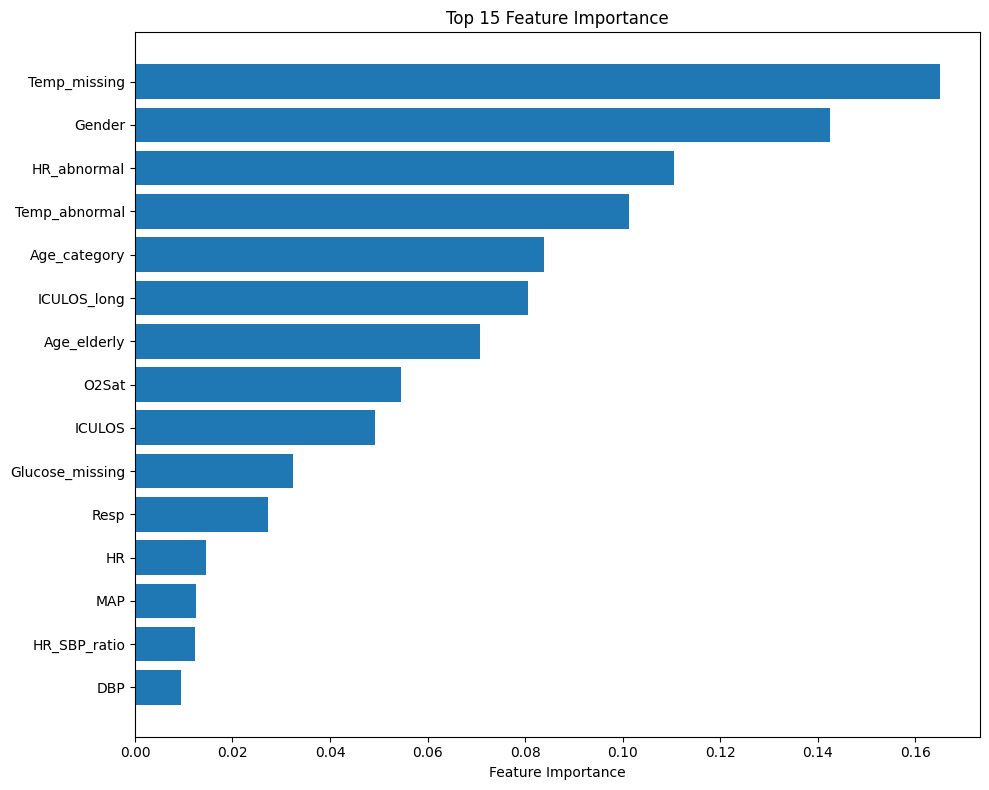

In [5]:
if __name__ == "__main__":
    main()